# Explore here

## Step 1: Problem statement and data collection

Problem statement: What price should an AirBnB host anticipate being able to charge, based on prices of existing AirBnBs with some similar and some different characteristics?

In [72]:


# Import dataset to start working with it
import pandas as pd

raw_data = pd.read_csv("../data/raw/AB_NYC_2019.csv")

def split_test_vs_training():
    test_frac = 0.20
    test_set  = raw_data.sample(frac=test_frac, random_state=42)
    train_set = raw_data.drop(test_set.index)



## Step 2: Exploration and data cleaning

In [73]:
print(f"Raw data shape: {raw_data.shape}")
print(raw_data.info())

Raw data shape: (48895, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last

Looks like the columns with missing data are: name, host_name, last_review, reviews_per_month.

Name and host_name should have negligible or no effect on price.
last_review and reviews_per_month sound plausible to indirectly correlate (i.e. a place with more reviews per time period likely got more bookings; more bookings correlates to less time unbooked; that correlates to a venue that is more in-demand and as such can likely charge a higher price per booking).

But we may be able to get away with ignoring them rather than trying to make some convoluted fictional values in place of missing values.

In [74]:
print(f"Count of duplicates found based on id: {raw_data.drop('id', axis = 1).duplicated().sum()}")

# Looks at every column except id. Two rows are considered the “same” if all of those other columns match, even when their id values differ.
#raw_data = raw_data.drop_duplicates(subset = raw_data.columns.difference(['id']))

#  Looks at all columns (because subset is omitted). Two rows are duplicates only if every column—including id—matches.
raw_data = raw_data.drop_duplicates()

print(raw_data.shape)
raw_data.head()

Count of duplicates found based on id: 0
(48895, 16)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [75]:
# remove data considered irrelevant
raw_data.drop(["id", "name", "host_name", "last_review", "reviews_per_month"], axis = 1, inplace = True)

# dropping lat & long because when I asked about them during office hours, 
# it sounded like it'd be bothersome to try to render something in Codespaces like a heatmap overlaid on a satellite map,
# and these sound in some ways redundant with neighborhood & neighborhood_groups anyway
raw_data.drop(["latitude", "longitude"], axis = 1, inplace = True)

raw_data.head()

,host_id,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
0,2787,Brooklyn,Kensington,Private room,149,1,9,6,365
1,2845,Manhattan,Midtown,Entire home/apt,225,1,45,2,355
2,4632,Manhattan,Harlem,Private room,150,3,0,1,365
3,4869,Brooklyn,Clinton Hill,Entire home/apt,89,1,270,1,194
4,7192,Manhattan,East Harlem,Entire home/apt,80,10,9,1,0


## Step 3: Analysis of univariate variables
### categorical variables
Categorical, non-numreric variables in this dataframe include: host_id, neighbourhood_group, neighbourhood, room_type

I can easily imagine a competent host being better-able to charge a high fee vs. someone less talented, so am including it in variables.

host_id looks numeric, but it's really just an anonymized form of name.  It can also exist across multiple properties managed by the same host, pulling the price in a similar up vs. down direction across each.


In [76]:
categorical_variables = ["host_id", "neighbourhood_group", "neighbourhood", "room_type"]

for each_categorical_variable in categorical_variables:
    print(f"\n\t{each_categorical_variable}s:")
    for each_possible_value in sorted(raw_data[f"{each_categorical_variable}"].unique()):
        print(each_possible_value)
        


	host_ids:
2438
2571
2787
2845
2868
2881
3151
3211
3415
3563
3647
3867
4396
4632
4869
5089
6041
6485
7192
7209
7310
7322
7351
7355
7356
7490
7500
7549
7702
7989
8198
8425
8440
8605
8703
8730
8967
9744
10135
10528
10889
11175
11481
11528
11975
12220
12221
14063
14356
14370
14444
14751
15154
15192
15387
15523
15574
15742
15784
15977
15991
16800
16866
17571
17930
17985
18174
18282
18283
18742
18946
19342
19402
19562
20805
20950
21188
21207
21248
21306
21475
21823
21904
22188
22323
22462
22486
23193
23276
23619
23633
23684
24069
24222
24347
25100
25183
25326
25459
25632
25810
26394
26640
27245
27848
28250
28336
28422
28573
29096
29213
29506
30193
30529
31374
31378
31994
32045
32169
32228
32294
32704
32800
33009
33510
33655
33816
34331
34915
35375
35935
35944
36119
36841
36897
37413
37879
38513
39260
39304
39322
40100
40275
40502
41358
41612
42032
42273
42761
43321
43671
43772
44145
44263
45009
45384
45445
45609
45682
46719
46969
46978
47459
47532
47610
47618
47727
48165
48581
48599
49405


2834840
2837527
2838058
2838365
2838615
2838861
2839267
2839817
2840710
2841152
2841175
2841374
2843970
2843987
2843998
2846279
2847655
2849280
2851131
2851409
2851789
2856748
2857722
2859398
2859516
2860131
2861103
2861768
2861820
2861848
2861854
2862308
2862643
2863092
2863689
2868153
2871975
2873394
2874126
2874433
2874587
2875590
2876700
2878358
2878510
2879920
2880794
2880824
2880848
2881763
2883347
2883788
2885147
2885704
2886359
2886652
2887101
2887402
2887664
2888900
2891643
2891898
2896601
2897021
2897329
2897622
2897835
2898343
2899508
2899693
2902266
2902496
2902737
2903063
2903817
2903840
2905589
2907609
2908101
2908180
2908554
2909294
2909990
2910317
2910509
2910527
2915668
2916281
2917387
2918667
2919299
2919467
2920855
2920976
2921076
2921109
2924286
2925596
2926404
2926593
2926947
2926954
2927446
2928002
2928681
2928701
2928867
2929585
2929756
2930303
2930482
2930761
2931626
2931897
2932525
2932668
2933058
2934010
2935265
2937468
2938204
2938302
2938381
2938550
2938649


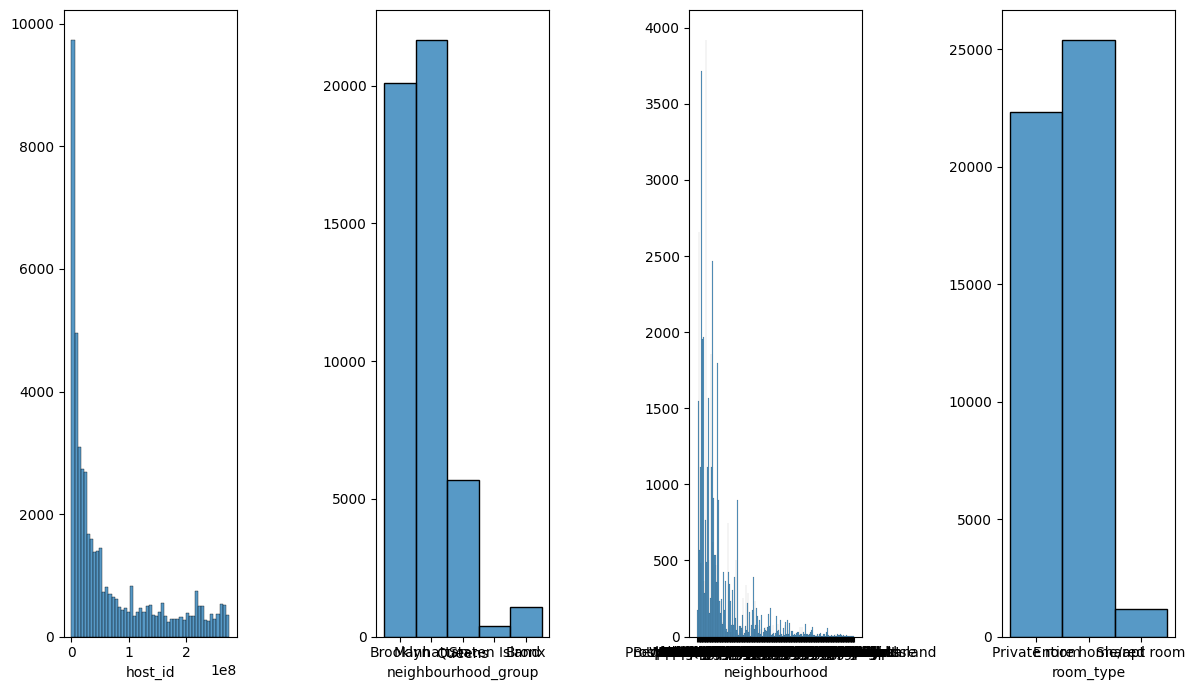

In [77]:
# histogram-plot each categorical variable

import matplotlib.pyplot as plt 
import seaborn as sns

fig, axis = plt.subplots(1, 4, figsize = (12, 7))

# Create a multiple histogram
sns.histplot(ax = axis[0], data = raw_data, x = "host_id").set(ylabel = None)
sns.histplot(ax = axis[1], data = raw_data, x = "neighbourhood_group").set(ylabel = None)
sns.histplot(ax = axis[2], data = raw_data, x = "neighbourhood").set(ylabel = None)
sns.histplot(ax = axis[3], data = raw_data, x = "room_type").set(ylabel = None)

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

- Most hosts had fewer than 1,750 listings, but a handful of perhaps-professionals had anywhere from >2,000 to nearly 10,000 listings.
- Most AirBnBs were in Brooklyn, Manhattan, or to a lesser extent Queens.
- Far more private or entire home/apartment rooms were listed; far fewer shared rooms.
- Certain neighborhoods were much more commonly listed than others; this likely corresponds to them being in more-represented neighborhood groups

### numeric variables

Numerical, non-categorical variables in the dataset include: price, minimum_nights, number_of_reviews, calculated_host_listings_count, availability_365.  

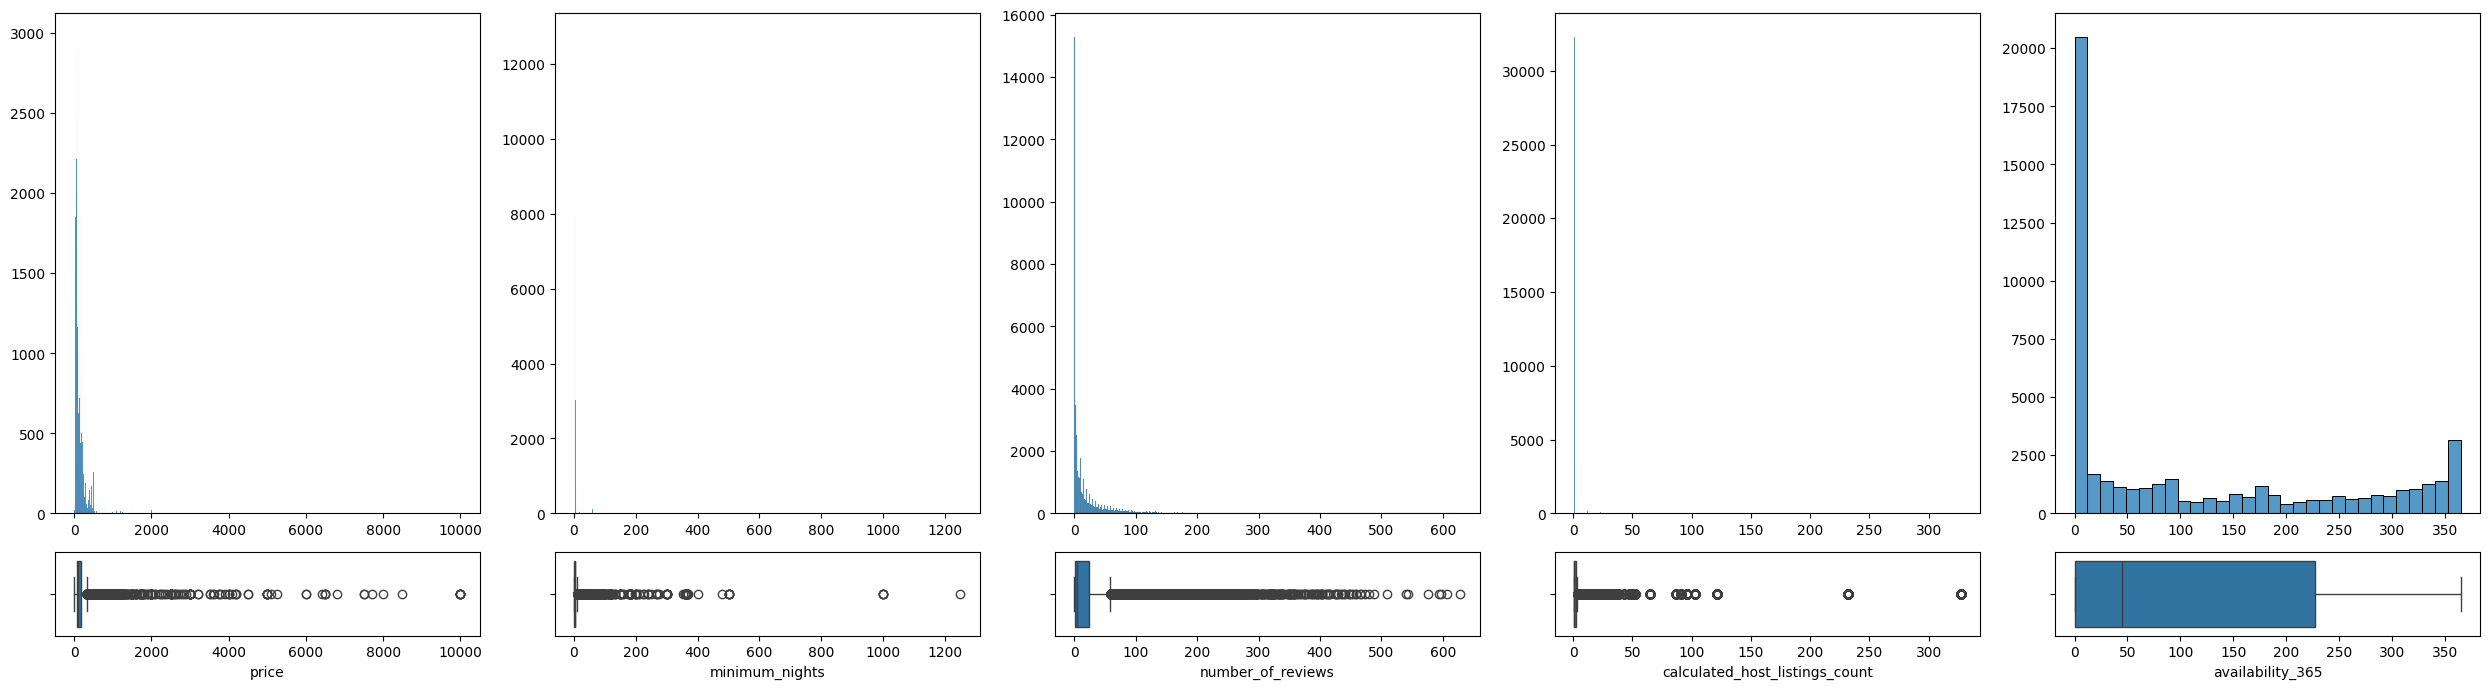

In [78]:
numeric_variables = ["price", "minimum_nights", "number_of_reviews", "calculated_host_listings_count", "availability_365"]
fig, axis = plt.subplots(2, len(numeric_variables), figsize = (25, 7), gridspec_kw={'height_ratios': [6, 1]})

# Creating a multiple figure with histograms and box plots
temp_column_index = 0
for each_numeric_variable in numeric_variables:
    sns.histplot(ax = axis[0, temp_column_index], data = raw_data, x = f"{each_numeric_variable}").set(xlabel = None,  ylabel = None)
    sns.boxplot(ax = axis[1, temp_column_index], data = raw_data, x = f"{each_numeric_variable}")
    temp_column_index += 1

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()


From this it looks like:
- most units charge under $500 (a night?) but there are some more-expensive outliers
- most places allow a minimum stay of only one night but at least a few outliers look like they're being listed for multi-year contracts
- most places have few if any reviews but the "tail" on that histogram skews longer into the low hundreds
- if I'm correctly understanding "calculated host listings count" then the majority of hosts have only a handful or at most a few dozen listings, whereas there are outliers who've listed dozens to hundreds
- many listings are available either only during a few nights of the year (maybe for popular holidays/events such as New Year's Eve or the Thanksgiving Day Parades?) and there's a noticeable histogram spike at beiung available year-round; the rest are typically available around 225 days a year. 

## Step 4: Analysis of multivariate variables